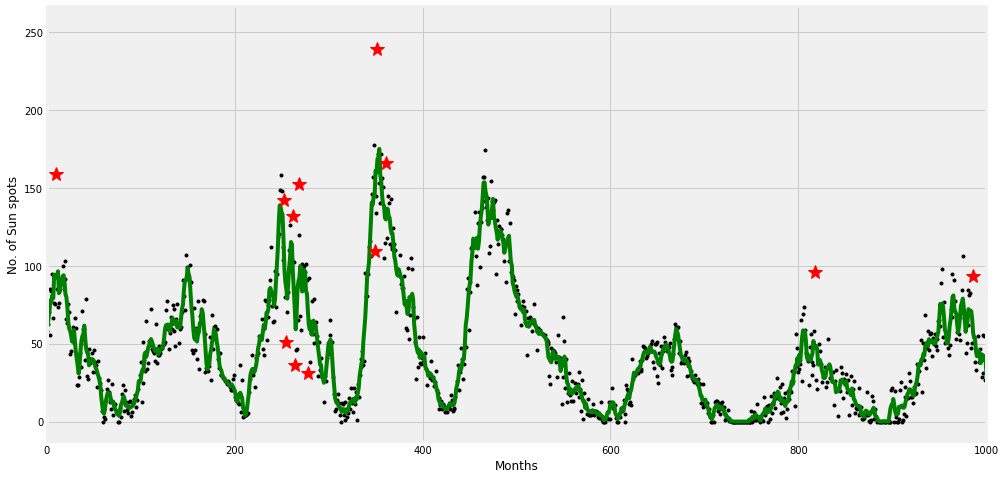

All Anomalies
+------+--------+
|Months|Sunspots|
+------+--------+
|  10.0|   158.6|
| 253.0|   142.5|
| 255.0|    51.0|
| 262.0|   132.2|
| 264.0|    36.0|
| 268.0|   152.7|
| 278.0|    31.1|
| 349.0|   109.3|
| 352.0|   238.9|
| 361.0|   165.7|
| 818.0|    96.2|
| 986.0|    93.4|
|1055.0|   206.3|
|1069.0|    84.8|
|1172.0|   107.1|
|1182.0|    52.2|
|1185.0|   180.4|
|1464.0|    88.3|
|1735.0|   129.2|
|1882.0|   107.2|
|1890.0|   103.6|
|1897.0|   108.2|
|2023.0|   154.5|
|2025.0|    72.2|
|2027.0|   129.3|
|2171.0|   108.0|
|2274.0|   165.3|
|2380.0|   201.3|
|2390.0|    94.8|
|2391.0|   189.7|
|2503.0|   158.0|
|2518.0|   152.3|
|2520.0|   217.4|
|2521.0|   143.1|
|2527.0|   199.6|
|2755.0|    58.1|
|2756.0|   138.2|
|2789.0|    90.9|
|2807.0|   127.0|
|2885.0|   196.2|
|2886.0|   126.9|
|2897.0|   105.4|
|2899.0|   200.3|
|3005.0|   137.7|
|3018.0|   170.1|
|3032.0|   150.7|
+------+--------+

None


In [10]:
import re, string
from pyspark.sql.window import Window
import pyspark.sql.functions as func
import matplotlib.pyplot as plt
from pyspark.sql.types import FloatType,IntegerType
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline

sunspots = sc.textFile('./sunspots.txt')
from pyspark.sql.functions import col,stddev

#Get month and sunspots 
sunspots_rdd = sunspots.map(lambda k: k.split("\t"))

sunspots_df = sunspots_rdd.toDF(['Months','Sunspots'])
sunspots_df = sunspots_df.withColumn("Months", sunspots_df["Months"].cast(FloatType()))
sunspots_df = sunspots_df.withColumn("Sunspots", sunspots_df["Sunspots"].cast(FloatType()))

def calc_window(window_size):
    if window_size%2 ==0:
        return -int(window_size/2)-1,int(window_size/2)
    else:
        return -int(window_size/2),int(window_size/2)
    
def moving_average_calc(sunspots_df,window_size):
    before,after = calc_window(window_size)
    windowSpec = Window.rowsBetween(before, after)
    return sunspots_df.withColumn('Moving average', func.avg("Sunspots").over(windowSpec)) 


def explain_anomalies(df_avg, window_size, sigma=1.0):
    df_avg = df_avg.withColumn("Residual", col("Sunspots")-col("Moving average"))
    std = df_avg.select(stddev(col('Residual')).alias('std')).collect()[0][0]
    
    return df_avg.filter((df_avg['Sunspots']>(df_avg['Moving average']+(sigma*std))) | \
                              (df_avg['Sunspots']<(df_avg['Moving average']-(sigma*std)))),std
        

def explain_anomalies_rolling_std(df_avg, window_size, sigma=1.0):
    #calculating residual
    df_avg = df_avg.withColumn("Residual", col("Sunspots")-col("Moving average"))
    
    #calculating rolling standard deviation
    before,after = calc_window(window_size)
    windowSpec = Window.rowsBetween(before, after)
    df_avg = df_avg.withColumn('Rolling STD', func.stddev("Residual").over(windowSpec))
    
    std = df_avg.select(stddev(col('Residual')).alias('std')).collect()[0][0]
    
    return df_avg.filter((df_avg['Sunspots']>(df_avg['Moving average']+(sigma*df_avg['Rolling STD']))) | \
                              (df_avg['Sunspots']<(df_avg['Moving average']-(sigma*df_avg['Rolling STD'])))), std


def plot_result(sunspots_df,window_size,sigma_value,apply_rolling_std=False):
    
    plt.figure(figsize=(15, 8))
     
    plt.plot(sunspots_df.select("Months").toPandas(), sunspots_df.select("Sunspots").toPandas(), "k.")
    plt.xlim(0, 1000)
    plt.xlabel("Months")
    plt.ylabel("No. of Sun spots")
    
    df_avg = moving_average_calc(sunspots_df, window_size)
    
    #plot all points
    plt.plot(sunspots_df.select("Months").toPandas(), df_avg.select("Moving average").toPandas(), color='green')
    
    #plot anomalies 
    if apply_rolling_std:
        anomalies,std = explain_anomalies_rolling_std(df_avg,window_size,sigma_value)
    else:
        anomalies,std = explain_anomalies(df_avg,window_size,sigma_value)
    plt.plot(anomalies.select("Months").toPandas(), anomalies.select("Sunspots").toPandas(), "r*", markersize=15)

    plt.grid(True)
    plt.show()
    
    print("All Anomalies")
    print(anomalies.select(['Months','Sunspots']).show(50))
   
    
plot_result(sunspots_df,window_size=5,sigma_value=3)